In [22]:
import os 
import json 
import pandas as pd 

import torch 
from transformers import AutoTokenizer, AutoModel, AutoConfig

from openai_api.task_decompostion import TaskDecomposer
from openai_api import gpt 

import preprocess_utils
import importlib
importlib.reload(preprocess_utils)
from preprocess_utils import OneRoundEvaluationDatasetAugmented

In [2]:
def cal_match(prediction, label):
    # 如果为空列表，说明没有激起任何工具
    if len(label) == 0:
        label = ('no corresponding tools.', '')
    # 否则取第一条工具，每个工具是一个元组
    else:
        label = label[0]
    target_intent = label[0]
    target_method = label[1]
    
    # 如果ai没有调用工具
    if isinstance(prediction, str):
        prediction_intent = 'no corresponding tools.'
        prediction_method = ''
    # 如果ai调用了工具则一定是一个字典
    else:
        try:
            prediction_intent = prediction.get('function', prediction.get('name'))
            prediction_method = prediction.get('arguments', prediction.get('parameters'))
        except:
            prediction_intent = list(prediction.keys())[0]
            prediction_method = prediction[prediction_intent]

    if prediction_intent == target_intent:
        if prediction_method == target_method:
            result = [1, 1]
        else:
            result = [1, 0]
    else:
        result = [0, 0]
    return result

In [3]:
def cal_chatglm(train_data, train_dataset, model, tokenizer, set_name, model_name, limit=100):
    print(set_name, model_name)
    results = []
    role = "user"
    for i in range(len(train_dataset)):
        print(i)
        if i == limit:
            break
        data = train_dataset[i]
        query = data["query"]
        # 如果target是[]，则说明query没有激起任何工具，no corresponding tools
        # 如果target不是空列表，则只取第一条分析
        target = data['query_target']
        num_decomposition = train_data[i]['num_decomposition']
        hit = train_data[i]['hit']
        if num_decomposition == 1:
            history = [data["history"]]
            try:
                response, history = model.chat(tokenizer, query, history=history, role=role)
            except:
                result = [-1, -1, 1, query, None]
            else:
                result = cal_match(response, target)
                result += [0, query, response]
            if not hit:
                result += ['no corresponding tools.']
            else:
                result += [target[0]]
            result += ['single_turn']
            result = [i] + result
        else:
            result = [i, -1, -1, -1, query, response, target, 'multi_turn']
        results.append(result)
    results = pd.DataFrame(results)
    results.columns = ['index', 'intent', 'slot', 'error', 'query', 'response', 'target', 'type']
    results = results.set_index('index')
    results['set_name'] = set_name
    results['model_name'] = model_name
    return results

In [4]:
def cal_openai(train_data, train_dataset, set_name, model_name, limit=100):
    print(set_name, model_name)
    with open('openai_api/configs/azure_openai_config_4.0.json', 'r') as f:
        config = json.load(f)
        gpt.openai_init(**config)
    
    llm = gpt.Gpt(config['model_name'], config['deployment_name'])
    results = []
    for i in range(0, len(train_data)):
        print(i)
        if i == limit:
            break
        data = train_dataset[i]
        query = data["query"]
        # 如果target是[]，则说明query没有激起任何工具，no corresponding tools
        # 如果target不是空列表，则只取第一条分析
        target = data['query_target']
        num_decomposition = train_data[i]['num_decomposition']
        hit = train_data[i]['hit']
        if num_decomposition == 1:
            task_decomposer = TaskDecomposer(llm,
                                             'openai_api/prompts/task_decomposition.txt',
                                             'openai_api/prompts/tools/robocontrol_test/task_decomposition_rr_api.json',
                                             'openai_api/few_shot_examples/task_decomposition.json',
                                             "User Requests:\n {user_request}\nAI: (The JSON (array) format output): ",
                                             )
            try:
                response = task_decomposer.run(query)
                if isinstance(response, list):
                    response = response[0]
            except:
                print('try failed', query)
                result = [-1, -1, 1, query, None]
            else:
                if response is None:
                    result = [-1, -1, 1, query, None]
                else:
                    result = cal_match(response, target)
                    result += [0, query, response]
            if not hit:
                result += ['no corresponding tools.']
            else:
                result += [target[0]]
            result += ['single_turn']
            result = [i] + result
        else:
            result = [i, -1, -1, -1, query, response, target, 'multi_turn']
        results.append(result)
    results = pd.DataFrame(results)
    results.columns = ['index', 'intent', 'slot', 'error', 'query', 'response', 'target', 'type']
    results = results.set_index('index')
    results['set_name'] = set_name
    results['model_name'] = model_name
    return results 

In [5]:
def cal_accuracy(results):
    num = results.shape[0]
    intent = results[(results['error'] == 0) & (results['type'] == 'single_turn')]['intent']
    zero_error_count = intent.shape[0]
    zero_error_rate = zero_error_count / num
    intent_sum, intent_mean = intent.sum(), intent.mean()
    slot = results[(results['error'] == 0) & (results['type'] == 'single_turn') & (results['intent'] == 1)]['slot']
    slot_sum, slot_mean = slot.sum(), slot.mean()
    both_mean = slot_sum / zero_error_count
    return pd.Series([num, zero_error_count, zero_error_rate, intent_sum, intent_mean, slot_sum, slot_mean, both_mean],
                     index=['num', 'zero_error_count', 'zero_error_rate', 'intent_sum', 'intent_mean', 'slot_sum', 'slot_mean', 'both_mean'])

In [24]:
tokenizer = AutoTokenizer.from_pretrained("/data/dataset/huggingface/hub/chatglm3-6b", trust_remote_code=True)

In [7]:
# 数据集概览

In [8]:
with open('formatted_data/robocontrol_dataset.jsonl', "r", encoding="utf-8") as f:
    if 'formatted_data/robocontrol_dataset.jsonl'.endswith(".json"):
        train_data = json.load(f)
    elif 'formatted_data/robocontrol_dataset.jsonl'.endswith(".jsonl"):
        train_data = [json.loads(line) for line in f]

In [9]:
train_dataset = OneRoundEvaluationDatasetAugmented(
    train_data,
    tokenizer,
    4096,
)

In [10]:
with open('formatted_data/robocontrol_dataset_testset.jsonl', "r", encoding="utf-8") as f:
    if 'formatted_data/robocontrol_dataset_testset.jsonl'.endswith(".json"):
        test_data = json.load(f)
    elif 'formatted_data/robocontrol_dataset_testset.jsonl'.endswith(".jsonl"):
        test_data = [json.loads(line) for line in f]

In [11]:
test_dataset = OneRoundEvaluationDatasetAugmented(
    test_data,
    tokenizer,
    4096,
)

In [97]:
df_train = pd.DataFrame()
hit = [i['hit'] for i in train_data]
num_decomposition = [i['num_decomposition'] for i in train_data]
df_train['hit'] = hit 
df_train['num_decomposition'] = num_decomposition
df_train['set'] = '1train'
df_test = pd.DataFrame()
hit = [i['hit'] for i in test_data]
num_decomposition = [i['num_decomposition'] for i in test_data]
df_test['hit'] = hit 
df_test['num_decomposition'] = num_decomposition
df_test['set'] = '2test'
df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
df['multi_turn'] = df['num_decomposition'] > 1
df['no_tools'] = (df['hit'] == False)

In [98]:
df.groupby('set').agg({'multi_turn': [len, 'sum', 'mean'], 'no_tools': ['sum', 'mean']})

multi_turn               no_tools          
              len sum      mean      sum      mean
set                                               
1train       3232   2  0.000619       47  0.014542
2test        1078   0  0.000000       19  0.017625

In [8]:
# 微调模型

In [13]:
# ptuning 128
# pt_checkpoint = "/root/PycharmProjects/ChatGLM3/finetune_chatmodel_demo/output/tool_alpaca_pt-20240108-191900-128-2e-2/checkpoint-250"  
# PRE_SEQ_LEN = int(os.environ.get("PRE_SEQ_LEN", 128))
# ptuning 256
pt_checkpoint = "/root/PycharmProjects/ChatGLM3/finetune_chatmodel_demo/output/tool_alpaca_pt-20240115-175737-256-2e-2/checkpoint-250"   
PRE_SEQ_LEN = int(os.environ.get("PRE_SEQ_LEN", 256))

In [14]:
if pt_checkpoint is not None and os.path.exists(pt_checkpoint):
    print('pt point found')
    config = AutoConfig.from_pretrained(
        "/data/dataset/huggingface/hub/models--THUDM--chatglm3-6b/snapshots/456aa875cf1f46623006edaa23103774ea9c0eae",
        trust_remote_code=True,
        pre_seq_len=PRE_SEQ_LEN,
        max_new_token=1024,
    )
    model = AutoModel.from_pretrained(
        "/data/dataset/huggingface/hub/models--THUDM--chatglm3-6b/snapshots/456aa875cf1f46623006edaa23103774ea9c0eae",
        trust_remote_code=True,
        config=config,
        device_map="auto"
    ).eval()
    prefix_state_dict = torch.load(os.path.join(pt_checkpoint, "pytorch_model.bin"))
    new_prefix_state_dict = {}
    for k, v in prefix_state_dict.items():
        if k.startswith("transformer.prefix_encoder."):
            new_prefix_state_dict[k[len("transformer.prefix_encoder."):]] = v
    print("Loaded from pt checkpoints", new_prefix_state_dict.keys())
    model.transformer.prefix_encoder.load_state_dict(new_prefix_state_dict)

pt point found


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /data/dataset/huggingface/hub/models--THUDM--chatglm3-6b/snapshots/456aa875cf1f46623006edaa23103774ea9c0eae and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded from pt checkpoints dict_keys(['embedding.weight'])


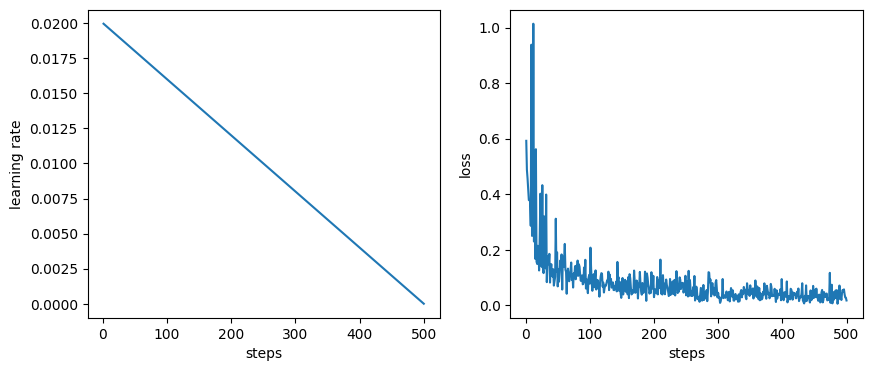

In [35]:
# ptuning 128
with open('output/tool_alpaca_pt-128-20240108-191900-128-2e-2/checkpoint-500/trainer_state.json', 'r') as file:
    log_history = json.load(file)['log_history']
step = [i['step'] for i in log_history]
learning_rate = [i['learning_rate'] for i in log_history]
loss = [i['loss'] for i in log_history]
import matplotlib.pyplot as plt 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(step, learning_rate)
ax2.plot(step, loss)
ax1.set_xlabel('steps')
ax1.set_ylabel('learning rate')
ax2.set_xlabel('steps')
ax2.set_ylabel('loss')
plt.show()

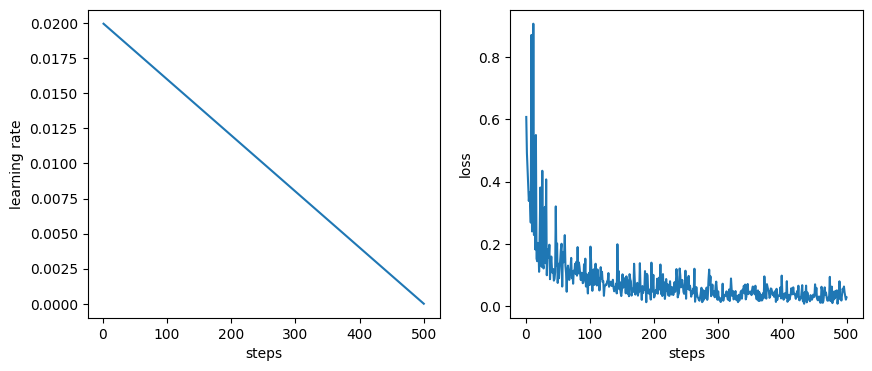

In [32]:
# ptuning 256
with open('output/tool_alpaca_pt-20240115-175737-256-2e-2/checkpoint-500/trainer_state.json', 'r') as file:
    log_history = json.load(file)['log_history']
step = [i['step'] for i in log_history]
learning_rate = [i['learning_rate'] for i in log_history]
loss = [i['loss'] for i in log_history]
import matplotlib.pyplot as plt 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(step, learning_rate)
ax2.plot(step, loss)
ax1.set_xlabel('steps')
ax1.set_ylabel('learning rate')
ax2.set_xlabel('steps')
ax2.set_ylabel('loss')
plt.show()

In [12]:
# 原始模型

In [13]:
model_raw = AutoModel.from_pretrained("/data/dataset/huggingface/hub/models--THUDM--chatglm3-6b/snapshots/456aa875cf1f46623006edaa23103774ea9c0eae", trust_remote_code=True)
model_raw = model_raw.to(1).eval()

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [69]:
# 随便看一个

In [18]:
data = train_dataset[5]
query = data['query']
history = [data["history"]]
role = "user"

In [19]:
response, history = model.chat(tokenizer, query, history=history, role=role)

In [20]:
query 

'Time to empty the wastewater tank'

In [21]:
data['query_target']

[('get_property', {'property_name': 'wastewater tank'})]

In [22]:
print(response)

{'name': 'do_not_or_skip_clean', 'parameters': {'location': 'wastewater tank'}}


In [75]:
history 

[{'role': 'system',
  'content': 'Answer the following questions as best as you can. You have access to the following tools:\n',
  'tools': '[{"name": "general_control", "description": "This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "user_defined_task": {"type": "string", "description": "user-defined task described in user request"}}, "required": ["operation_type"]}}, {"name": "clean", "description": "Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "location": {"type": "string", "description": "Fill in the description of the 

In [ ]:
# 统计分析

In [15]:
final = []
final.append(cal_chatglm(train_data, train_dataset, model, tokenizer, set_name='1train', model_name='1finetune', limit=100))
final.append(cal_chatglm(test_data, test_dataset, model, tokenizer, set_name='2test', model_name='1finetune', limit=100))
final.append(cal_chatglm(train_data, train_dataset, model_raw, tokenizer, set_name='1train', model_name='2raw', limit=100))
final.append(cal_chatglm(test_data, test_dataset, model_raw, tokenizer, set_name='2test', model_name='2raw', limit=100))

1train 1finetune
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
2test 1finetune
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


NameError: name 'model_raw' is not defined

In [ ]:
final.append(cal_openai(train_data, train_dataset, set_name='1train', model_name='3openai', limit=100))
final.append(cal_openai(test_data, test_dataset, set_name='2test', model_name='3openai', limit=100))

In [16]:
final = pd.concat(final, axis=0).reset_index(drop=True)

In [104]:
final.to_csv('robocontrol.csv', index=None)

In [17]:
# ptuning 256
final.groupby(['model_name', 'set_name']).apply(cal_accuracy)

num  zero_error_count  zero_error_rate  intent_sum  \
model_name set_name                                                         
1finetune  1train    100.0              97.0             0.97        57.0   
           2test     100.0              98.0             0.98        55.0   

                     intent_mean  slot_sum  slot_mean  both_mean  
model_name set_name                                               
1finetune  1train       0.587629      27.0   0.473684   0.278351  
           2test        0.561224      23.0   0.418182   0.234694

In [83]:
final.groupby(['model_name', 'set_name']).apply(cal_accuracy)

num  zero_error_count  zero_error_rate  intent_sum  \
model_name set_name                                                         
1finetune  1train    100.0              97.0             0.97        60.0   
           2test     100.0             100.0             1.00        62.0   
2raw       1train    100.0              99.0             0.99        28.0   
           2test     100.0             100.0             1.00        23.0   
3openai    1train    100.0              95.0             0.95        90.0   
           2test     100.0              94.0             0.94        89.0   

                     intent_mean  slot_sum  slot_mean  both_mean  
model_name set_name                                               
1finetune  1train       0.618557      29.0   0.483333   0.298969  
           2test        0.620000      30.0   0.483871   0.300000  
2raw       1train       0.282828       3.0   0.107143   0.030303  
           2test        0.230000       7.0   0.304348   0.070000  
3openai    1train       0.947368      73.0   0.811111   0.768421  
           2test        0.946809      69.0   0.775281   0.734043